In [1]:
!pip install krakenex

In [2]:
!pip install pykrakenapi

In [3]:
import krakenex 
from pykrakenapi import KrakenAPI
import sys
import time
import urllib.request
import json
import requests
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
api = krakenex.API()
k = KrakenAPI(api)

In [5]:
ohlc = k.get_ohlc_data("BTCUSD")
print(ohlc)

(                           time     open     high      low    close     vwap  \
dtime                                                                          
2021-06-07 16:31:00  1623083460  35785.7  35808.4  35785.7  35808.4  35798.6   
2021-06-07 16:30:00  1623083400  35808.3  35808.3  35774.7  35785.5  35785.2   
2021-06-07 16:29:00  1623083340  35832.0  35832.0  35787.2  35807.5  35817.5   
2021-06-07 16:28:00  1623083280  35816.9  35867.1  35764.2  35839.3  35812.5   
2021-06-07 16:27:00  1623083220  35796.2  35824.0  35790.9  35824.0  35812.3   
...                         ...      ...      ...      ...      ...      ...   
2021-06-07 04:36:00  1623040560  36357.5  36357.5  36328.4  36338.0  36351.5   
2021-06-07 04:35:00  1623040500  36348.3  36359.2  36348.3  36359.2  36355.7   
2021-06-07 04:34:00  1623040440  36299.9  36348.3  36299.9  36348.3  36337.9   
2021-06-07 04:33:00  1623040380  36285.7  36299.5  36285.7  36299.5  36294.7   
2021-06-07 04:32:00  1623040320  36274.

In [6]:
def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200: 
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)
    return data

In [7]:
btc = fetch_OHLC_data(symbol="BTC/USD", timeframe="1440")
btc = btc.drop(columns=["unix", "open", "high", "low", "vwap", "volume", "tradecount", "volume_from"])
btc = btc.set_index("date")
btc

,close
date,
2019-06-19,9277.1
2019-06-20,9534.3
2019-06-21,10219.2
2019-06-22,10663.8
2019-06-23,10814.1
...,...
2021-06-03,39196.6
2021-06-04,36847.7
2021-06-05,35534.6


In [8]:

btc['close'] = btc['close'].astype(float)
btc['returns'] = btc.close.pct_change()
btc['change_in_price'] = btc['returns']
btc.change_in_price[btc.change_in_price > 0] = 1
btc.change_in_price[btc.change_in_price <= 0] = 0
btc.dropna(inplace=True)
btc['change_in_price'] = btc['change_in_price'].astype(int)
btc

,close,returns,change_in_price
date,,,
2019-06-20,9534.3,0.027724,1
2019-06-21,10219.2,0.071835,1
2019-06-22,10663.8,0.043506,1
2019-06-23,10814.1,0.014094,1
2019-06-24,11020.6,0.019095,1
...,...,...,...
2021-06-03,39196.6,0.043426,1
2021-06-04,36847.7,-0.059926,0
2021-06-05,35534.6,-0.035636,0


In [9]:
def generate_signals(btc):
    """Generates trading signals for a given dataset."""
    # Grab just the `date` and `close` from the IEX dataset
    signals_df = btc.copy()
    # Set the short window and long windows
    short_window = 50
    long_window = 100
    # Generate the short and long moving averages (50 and 100 days, respectively)
    signals_df["SMA50"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA100"] = signals_df["close"].rolling(window=long_window).mean()
    signals_df["Signal"] = 0.0
    # Generate the trading signal 0 or 1,
    # where 0 is when the SMA50 is under the SMA100, and
    # where 1 is when the SMA50 is higher (or crosses over) the SMA100
    signals_df["Signal"][short_window:] = np.where(
        signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:],
        1.0,
        0.0,
    )
    # Calculate the points in time at which a position should be taken, 1 or -1
    signals_df["Entry/Exit"] = signals_df["Signal"].diff()
    return signals_df

In [10]:
mov_avg = generate_signals(btc)
mov_avg.tail()

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,close,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit
date,,,,,,,
2021-06-03,39196.6,0.043426,1,48760.844,52013.217,0.0,0.0
2021-06-04,36847.7,-0.059926,0,48232.938,51884.417,0.0,0.0
2021-06-05,35534.6,-0.035636,0,47714.530,51769.148,0.0,0.0
2021-06-06,35789.0,0.007159,1,47228.606,51663.893,0.0,0.0
2021-06-07,35785.5,-0.000098,0,46819.520,51560.046,0.0,0.0


In [11]:
bollinger_window = 20

# Calculate rolling mean and standard deviation
all_sig = mov_avg.copy()
all_sig['bollinger_mid_band'] = mov_avg['close'].rolling(window=bollinger_window).mean()
all_sig['bollinger_std'] = mov_avg['close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
all_sig['bollinger_upper_band']  = all_sig['bollinger_mid_band'] + (all_sig['bollinger_std'] * 1)
all_sig['bollinger_lower_band']  = all_sig['bollinger_mid_band'] - (all_sig['bollinger_std'] * 1)

all_sig

,close,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band
date,,,,,,,,,,,
2019-06-20,9534.3,0.027724,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-21,10219.2,0.071835,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2019-06-22,10663.8,0.043506,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2019-06-23,10814.1,0.014094,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2019-06-24,11020.6,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,39196.6,0.043426,1,48760.844,52013.217,0.0,0.0,38915.735,3521.755172,42437.490172,35393.979828
2021-06-04,36847.7,-0.059926,0,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873
2021-06-05,35534.6,-0.035636,0,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874


In [12]:
X = all_sig.copy()
X.dropna(inplace=True)
X.drop(columns=['close','returns','change_in_price'], inplace=True)
X.head()

,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band
date,,,,,,,,
2019-09-27,10175.894,10525.262,0.0,0.0,9820.860,798.797709,10619.657709,9022.062291
2019-09-28,10103.012,10512.054,0.0,0.0,9711.105,862.088116,10573.193116,8849.016884
2019-09-29,10038.380,10490.393,0.0,0.0,9598.035,924.802142,10522.837142,8673.232858
2019-09-30,9974.046,10466.855,0.0,0.0,9508.810,959.804138,10468.614138,8549.005862
2019-10-01,9912.822,10441.944,0.0,0.0,9416.925,981.823851,10398.748851,8435.101149


In [13]:
y=all_sig['change_in_price'].values.reshape(-1,1)
y=y[99:]
y[:5]

array([[1],
       [1],
       [0],
       [1],
       [1]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [15]:
scaler = StandardScaler()

In [16]:
X_scaler = scaler.fit(X_train)

In [17]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [27]:
rf_model = rf_model.fit(X_train_scaled, y_train)

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [28]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [29]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)



In [30]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,32,37
Actual 1,54,32


Accuracy Score : 0.4129032258064516
Classification Report
              precision    recall  f1-score   support

           0       0.37      0.46      0.41        69
           1       0.46      0.37      0.41        86

    accuracy                           0.41       155
   macro avg       0.42      0.42      0.41       155
weighted avg       0.42      0.41      0.41       155



In [31]:
# Get the feature importance array
importances = rf_model.feature_importances_


In [32]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]


[(0.1814874176728081, 'bollinger_std'),
 (0.1672698246578319, 'bollinger_lower_band'),
 (0.1653067741065758, 'bollinger_upper_band'),
 (0.16187567506371678, 'SMA50'),
 (0.15927731502429668, 'SMA100'),
 (0.15452611989382783, 'bollinger_mid_band'),
 (0.007156920177896288, 'Signal'),
 (0.00309995340304662, 'Entry/Exit')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

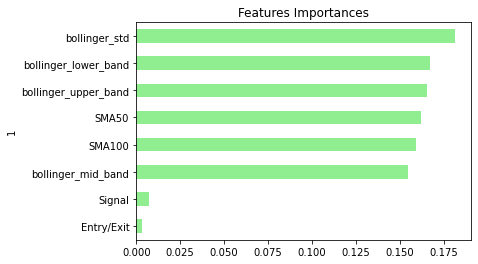

In [33]:
# Visualize the features by importance
importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances.set_index(importances[1], inplace=True)
importances.drop(columns=1, inplace=True)
importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)
